# Group Assignments

Group 4, Responsible Machine Learning

Updated 2021-06-14


**Assignment 1 Remarks:**  We tested different values for some hyperparameters - see remarks within each section for brief explanations.  Unfortunately, this had a negligible effect on AUC for each of the 3 models.

**Assignment 2 Remarks:**  We leveraged feature interpretation code from the template code as-is.

**Assignment 3 Remarks:**  AIR and remediate Discovered Discrimination.


#### Imports and inits

In [1]:
import datetime                                               # for timestamp 
import h2o                                                    # base h2o package for python
from h2o.estimators.glm import H2OGeneralizedLinearEstimator  # h2o elastic net models class
from h2o.grid.grid_search import H2OGridSearch                # grid search class and syntax for h2o models
from interpret import show                                    # basic visualizations from interpret package
from interpret.glassbox import ExplainableBoostingClassifier  # interpret ebm class
from interpret.perf import ROC                                # ROC measure for ebm
import itertools                                              # for cartesian product of parameters
import matplotlib.pyplot as plt                               # basic plotting
import numpy as np                                            # for basic array manipulation                            
import pandas as pd                                           # for dataframe manipulation
import seaborn as sns                                         # slightly better plotting  
import time                                                   # for timers
import xgboost as xgb                                         # base xgboost package for python

# set numpy random seed for better reproducibility
SEED = 1988 

# set number of threads
NTHREAD = 4

h2o.init(max_mem_size='10G', nthreads=NTHREAD) # start h2o with plenty of memory and threads
h2o.remove_all()                              # clears h2o memory
h2o.no_progress()                             # turn off h2o progress indicators    

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: java version "1.8.0_101"; Java(TM) SE Runtime Environment (build 1.8.0_101-b13); Java HotSpot(TM) 64-Bit Server VM (build 25.101-b13, mixed mode)
  Starting server from /Users/Calvin/opt/anaconda3/lib/python3.8/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/zv/3zl6flxj48b7kcbzwz8srn3h0000gn/T/tmps2_rle8e
  JVM stdout: /var/folders/zv/3zl6flxj48b7kcbzwz8srn3h0000gn/T/tmps2_rle8e/h2o_Calvin_started_from_python.out
  JVM stderr: /var/folders/zv/3zl6flxj48b7kcbzwz8srn3h0000gn/T/tmps2_rle8e/h2o_Calvin_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,America/New_York
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.32.1.3
H2O_cluster_version_age:,25 days
H2O_cluster_name:,H2O_from_python_Calvin_rb42k5
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,8.89 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"accepting new members, healthy"


In [6]:
from interpret.glassbox import ExplainableBoostingClassifier  # interpret ebm class
from interpret.perf import ROC                                # ROC measure for ebm
import itertools                                              # for cartesian product of parameters
import matplotlib.pyplot as plt                               # for plots
import numpy as np                                            # for basic array manipulation                            
import pandas as pd                                           # for dataframe manipulation
import random                                                 # to sample from lists
from sklearn.metrics import accuracy_score, f1_score          # for selecting model cutoffs
import time                                                   # for timers

# set numpy random seed for better reproducibility
SEED = 12345 
np.random.seed(SEED)

# set number of threads
NTHREAD = 4

#### Start global timer

In [2]:
tic = time.time()

#### Import data

In [4]:
data = pd.read_csv('hmda_train_preprocessed.csv')
test = pd.read_csv('hmda_test_preprocessed.csv')

#### Assign basic modeling roles

In [7]:
y_name = 'high_priced'
x_names = ['term_360', 'conforming', 'debt_to_income_ratio_missing', 'loan_amount_std', 'loan_to_value_ratio_std', 'no_intro_rate_period_std',
           'intro_rate_period_std', 'property_value_std', 'income_std', 'debt_to_income_ratio_std']

## Basic data exploration

#### Histograms

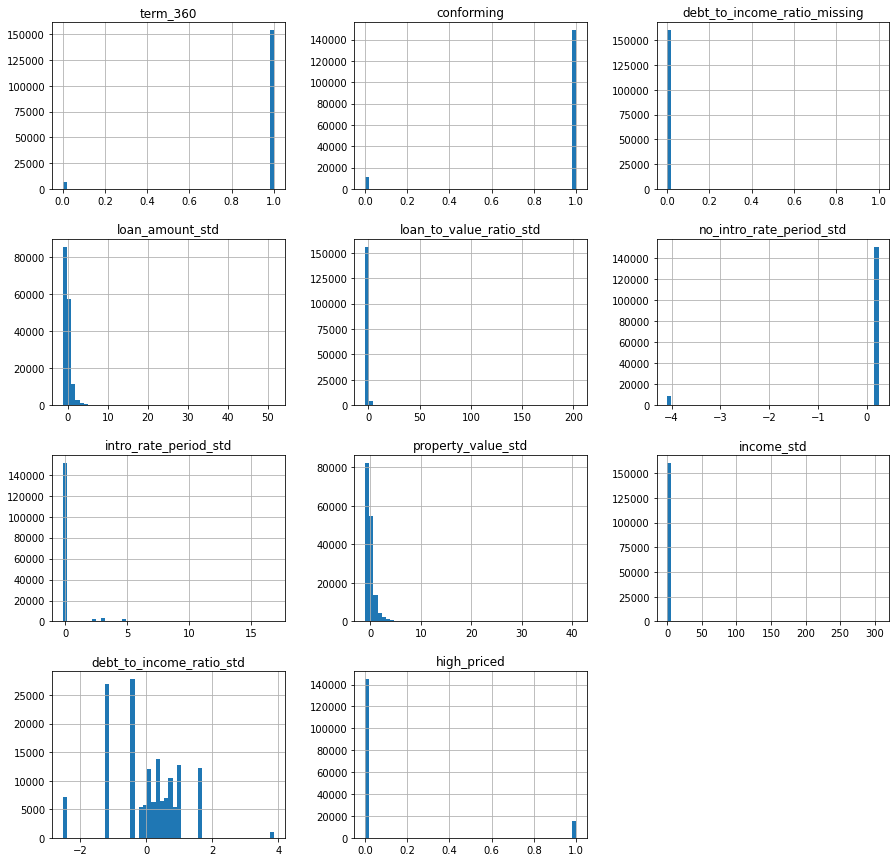

In [5]:
_ = data[x_names + [y_name]].hist(bins=50, figsize=(15, 15))

#### Correlations

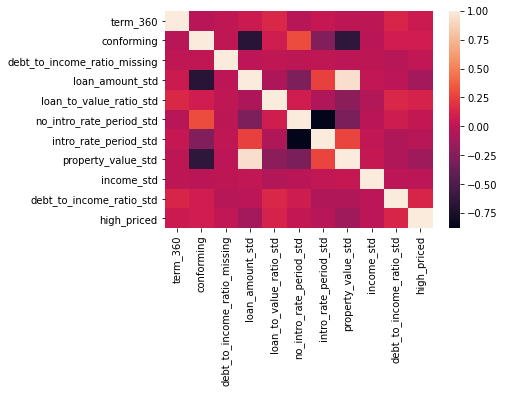

In [6]:
corr = data[x_names + [y_name]].corr()
_ = sns.heatmap(corr, 
                xticklabels=corr.columns.values,
                yticklabels=corr.columns.values)

## Fit interpretable models

#### Split data into train and validation partitions 

In [8]:
np.random.seed(SEED) # preserve exact reproducibility for this cell

split_ratio = 0.7 # 70%/30% train/test split

# execute split
split = np.random.rand(len(data)) < split_ratio
train = data[split]
valid = data[~split]

# summarize split
print('Train data rows = %d, columns = %d' % (train.shape[0], train.shape[1]))
print('Validation data rows = %d, columns = %d' % (valid.shape[0], valid.shape[1]))

# benchmark - Train data rows = 112253, columns = 23
# benchmark - Validation data rows = 48085, columns = 23

Train data rows = 112253, columns = 23
Validation data rows = 48085, columns = 23


### Elastic net

#### Define wrapper function for grid search

**Remarks:**  We tested additional L2 values outside the template: extremes closer to 0 and 1, and also 0.75.

In [8]:
def glm_grid(x_names, y_name, htrain, hvalid, seed):

    """ Wrapper function for penalized GLM with alpha and lambda search.

    :param x_names: Names of input features.
    :param y_name: Name of target feature.
    :param htrain: Training H2OFrame.
    :param hvalid: Validation H2OFrame.
    :param seed: Random seed for better reproducibility.
    :return: Best H2OGeneralizedLinearEstimator.
    """

    alpha_opts = [0.005, 0.01, 0.25, 0.5, 0.75, 0.99, 0.995]  # always keep some L2

    # define search criteria
    # i.e., over alpha
    # lamda search handled by lambda_search param below
    hyper_parameters = {'alpha': alpha_opts}

    # initialize grid search
    grid = H2OGridSearch(
        H2OGeneralizedLinearEstimator(family='binomial',
                                      lambda_search=True,
                                      seed=seed), # seed for grid search
        hyper_params=hyper_parameters)

    # execute training w/ grid search
    grid.train(y=y_name,
               x=x_names,
               training_frame=htrain,
               validation_frame=hvalid,
               seed=seed) # seed for training

    # select best model from grid search
    best_model = grid.get_grid()[0]
    del grid

    return best_model

#### Fit elastic net with grid search

In [9]:
# start local timer
glm_tic = time.time()

# convert data to h2o frames
htrain = h2o.H2OFrame(train)
hvalid = h2o.H2OFrame(valid)

# train with grid search
best_glm = glm_grid(x_names, y_name, htrain, hvalid, SEED)

# end local timer
glm_toc = time.time() - glm_tic
print('Elastic net GLM training completed in %.2f s.' % (glm_toc))

Elastic net GLM training completed in 45.60 s.


#### Basic AUC assessment

In [10]:
print('Validation AUC: %.4f.' % best_glm.auc(valid=True))

Validation AUC: 0.7568.


Score validation data with model

In [11]:
best_glm_phat = best_glm.predict(hvalid).as_data_frame() 
best_glm_phat.drop(['predict', 'p0'], axis=1, inplace=True)
best_glm_phat.columns = ['phat']
best_glm_phat = pd.concat([valid.reset_index(drop=True), best_glm_phat], axis=1)
best_glm_phat.head()

,row_id,black,asian,white,amind,hipac,hispanic,non_hispanic,male,female,...,debt_to_income_ratio_missing,loan_amount_std,loan_to_value_ratio_std,no_intro_rate_period_std,intro_rate_period_std,property_value_std,income_std,debt_to_income_ratio_std,high_priced,phat
0,3,0.0,0.0,1.0,0.0,0.0,0.0,1.0,NaN,NaN,...,0,-0.074670,-1.150240,0.244394,-0.215304,0.358276,-0.018133,-0.425131,0,0.066952
1,7,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0,-0.734255,0.552520,0.244394,-0.215304,-0.720941,-0.039614,0.488963,0,0.135121
2,14,0.0,0.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN,...,0,-0.426448,0.355249,0.244394,-0.215304,-0.474263,-0.027488,-1.156406,0,0.092623
3,16,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0,-0.866172,1.630935,0.244394,-0.215304,-0.875115,-0.041693,1.585876,1,0.196862
4,19,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0,-0.558366,0.115325,0.244394,-0.215304,-0.535932,-0.035803,-0.150903,0,0.107695


Utility function for selecting percentiles

In [12]:
def get_percentile_dict(yhat_name, frame, id_):

    """ Returns the percentiles of a column, yhat_name, as the indices based on
        another column id_.
        :param yhat_name: Name of column in frame in which to find percentiles.
        :param frame: Pandas frame.
        :param id_: Validation Pandas frame containing yhat and id_.
        :return: Dictionary of percentile values and index column values.
    """

    # create a copy of frame and sort it by yhat
    sort_df = frame.copy(deep=True)
    sort_df.sort_values(yhat_name, inplace=True)
    sort_df.reset_index(inplace=True)

    # find top and bottom percentiles
    percentiles_dict = {0: sort_df.loc[0, id_], 99: sort_df.loc[sort_df.shape[0] - 1, id_]}

    # find 10th-90th percentiles
    inc = sort_df.shape[0] // 10
    for i in range(1, 10):
        percentiles_dict[i * 10] = sort_df.loc[i * inc, id_]

    return percentiles_dict

Select percentiles from predictions

In [13]:
best_glm_percentiles = get_percentile_dict('phat', best_glm_phat, 'row_id')
for key in sorted(best_glm_percentiles.keys()):
    print(str(key) + ': ' + str(best_glm_percentiles[key]))

0: 7465
10: 127647
20: 101451
30: 1811
40: 160267
50: 125741
60: 154218
70: 27845
80: 153737
90: 7738
99: 111880


Collect global feature importance info

In [14]:
# use coefficients as relative global feature importance
global_fi = pd.DataFrame.from_dict(best_glm.coef(), columns=['GLM Importance'], orient='index')
global_fi.drop('Intercept', inplace=True)
global_fi['GLM Importance'] = np.abs(global_fi['GLM Importance'])

Collect local feature importance info

In [15]:
# use (coefficient * value) as local feature importance

# init frame to store local contribs
local_fi_dict = {10: pd.DataFrame(columns = ['GLM Contribution'], index=x_names),
                 50: pd.DataFrame(columns = ['GLM Contribution'], index=x_names),
                 90: pd.DataFrame(columns = ['GLM Contribution'], index=x_names)}

# get (coefficient * value) at three percentiles of phat
for name in x_names:
    for percentile in [10, 50, 90]:
    
        # local contributions = beta_j * x_i,j
        local_fi_dict[percentile].loc[name, 'GLM Contribution'] =\
            best_glm.coef()[name] *\
            valid[valid['row_id'] == int(best_glm_percentiles[percentile])][name].values[0]

#### Write submission file

In [16]:
best_glm_submit = best_glm.predict(h2o.H2OFrame(test)).as_data_frame() 
best_glm_submit.drop(['predict', 'p0'], axis=1, inplace=True)
best_glm_submit.columns = ['phat']
best_glm_submit.to_csv('group4_best_glm_' + str(datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S") + '.csv'), 
                       index=False)

### Monotonic XGBoost

#### Define utility function for random grid search

In [17]:
def xgb_grid(dtrain, dvalid, mono_constraints=None, gs_params=None, n_models=None,
             ntree=None, early_stopping_rounds=None, verbose=False, seed=None):
    
    """ Performs a random grid search over n_models and gs_params.

    :param dtrain: Training data in LightSVM format.
    :param dvalid: Validation data in LightSVM format.
    :param mono_constraints: User-supplied monotonicity constraints.
    :param gs_params: Dictionary of lists of potential XGBoost parameters over which to search.
    :param n_models: Number of random models to evaluate.
    :param ntree: Number of trees in XGBoost model.
    :param early_stopping_rounds: XGBoost early stopping rounds.
    :param verbose: Whether to display training iterations, default False.
    :param seed: Random seed for better interpretability.
    :return: Best candidate model from random grid search.

    """

    # cartesian product of gs_params
    keys, values = zip(*gs_params.items())
    experiments = [dict(zip(keys, v)) for v in itertools.product(*values)]

    # preserve exact reproducibility for this function
    np.random.seed(SEED) 
    
    # select randomly from cartesian product space
    selected_experiments = np.random.choice(len(experiments), n_models)

    # set global params for objective,  etc.
    params = {'booster': 'gbtree',
              'eval_metric': 'auc',
              'nthread': NTHREAD,
              'objective': 'binary:logistic',
              'seed': SEED}

    # init grid search loop
    best_candidate = None
    best_score = 0

    # grid search loop
    for i, exp in enumerate(selected_experiments):

        params.update(experiments[exp])  # override global params with current grid run params

        print('Grid search run %d/%d:' % (int(i + 1), int(n_models)))
        print('Training with parameters:', params)

        # train on current params
        watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
        
        if mono_constraints is not None:
            params['monotone_constraints'] = mono_constraints
        
        candidate = xgb.train(params,
                              dtrain,
                              ntree,
                              early_stopping_rounds=early_stopping_rounds,
                              evals=watchlist,
                              verbose_eval=verbose)    

        # determine if current model is better than previous best
        if candidate.best_score > best_score:
            best_candidate = candidate
            best_score = candidate.best_score
            print('Grid search new best score discovered at iteration %d/%d: %.4f.' %
                             (int(i + 1), int(n_models), candidate.best_score))

        print('---------- ----------')
            
    return best_candidate

#### Fit monotonic XGBoost with random grid search

**Remarks:**  We tested additional hyperparameter values outside the template:

- Tree depth values of lesser and greater than the range in the template

- Larger value for min_child_weight than the range in the template

In [18]:
# dictionary of hyperparameter value lists for grid search
gs_params = {'colsample_bytree': [0.3, 0.5, 0.7, 0.9],
             'colsample_bylevel': [0.3, 0.5, 0.7, 0.9],
             'eta': [0.005, 0.05, 0.5],
             'max_depth': [1, 3, 5, 7, 9],
             'reg_alpha': [0.0005, 0.005, 0.05],
             'reg_lambda': [0.0005, 0.005, 0.05],
             'subsample': [0.3, 0.5, 0.7, 0.9],
             'min_child_weight': [1, 5, 10, 15], 
             'gamma': [0.0, 0.1, 0.2 , 0.3, 0.4]}

# define monotonicity constraints
mono_constraints = tuple([int(i) for i in np.sign(train[x_names + [y_name]].corr()[y_name].values[:-1])])

# start local timer
mxgb_tic = time.time()

# Convert data to SVMLight format
dtrain = xgb.DMatrix(train[x_names], train[y_name])
dvalid = xgb.DMatrix(valid[x_names], valid[y_name])

# Monotonic XGBoost grid search
best_mxgb = xgb_grid(dtrain, dvalid, gs_params=gs_params, n_models=50, ntree=1000, early_stopping_rounds=100, 
                     mono_constraints=mono_constraints, seed=SEED)

# end local timer
mxgb_toc = time.time() - mxgb_tic
print('Monotonic GBM training completed in %.2f s.' % (mxgb_toc))

nary:logistic', 'seed': 1988, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.7, 'eta': 0.5, 'max_depth': 1, 'reg_alpha': 0.005, 'reg_lambda': 0.0005, 'subsample': 0.3, 'min_child_weight': 5, 'gamma': 0.0, 'monotone_constraints': (1, 1, 1, -1, 1, 1, -1, -1, -1, 1)}
---------- ----------
Grid search run 4/50:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 1988, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.3, 'eta': 0.005, 'max_depth': 7, 'reg_alpha': 0.005, 'reg_lambda': 0.005, 'subsample': 0.3, 'min_child_weight': 1, 'gamma': 0.1, 'monotone_constraints': (1, 1, 1, -1, 1, 1, -1, -1, -1, 1)}
---------- ----------
Grid search run 5/50:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 1988, 'colsample_bytree': 0.3, 'colsample_bylevel': 0.3, 'eta': 0.005, 'max_depth': 3, 'reg_alpha': 0.0005, 'reg_lambda': 0.05, 'subsample': 0.7, 'min_chil

#### Basic AUC assessment

In [19]:
print('Validation AUC: %.4f.' % best_mxgb.best_score)

Validation AUC: 0.7880.


Score validation data with model

In [20]:
best_mxgb_phat = pd.DataFrame(best_mxgb.predict(dvalid, ntree_limit=best_mxgb.best_ntree_limit), columns=['phat']) 
best_mxgb_phat = pd.concat([valid.reset_index(drop=True), best_mxgb_phat], axis=1)
best_mxgb_phat.head()

C:\Users\cbett\miniconda3\lib\site-packages\xgboost\core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


,row_id,black,asian,white,amind,hipac,hispanic,non_hispanic,male,female,...,debt_to_income_ratio_missing,loan_amount_std,loan_to_value_ratio_std,no_intro_rate_period_std,intro_rate_period_std,property_value_std,income_std,debt_to_income_ratio_std,high_priced,phat
0,3,0.0,0.0,1.0,0.0,0.0,0.0,1.0,NaN,NaN,...,0,-0.074670,-1.150240,0.244394,-0.215304,0.358276,-0.018133,-0.425131,0,0.009716
1,7,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0,-0.734255,0.552520,0.244394,-0.215304,-0.720941,-0.039614,0.488963,0,0.287038
2,14,0.0,0.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN,...,0,-0.426448,0.355249,0.244394,-0.215304,-0.474263,-0.027488,-1.156406,0,0.086767
3,16,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0,-0.866172,1.630935,0.244394,-0.215304,-0.875115,-0.041693,1.585876,1,0.861828
4,19,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0,-0.558366,0.115325,0.244394,-0.215304,-0.535932,-0.035803,-0.150903,0,0.059117


Select percentiles from predictions

In [21]:
best_mxgb_percentiles = get_percentile_dict('phat', best_mxgb_phat, 'row_id')
for key in sorted(best_mxgb_percentiles.keys()):
    print(str(key) + ': ' + str(best_mxgb_percentiles[key]))

0: 115088
10: 9407
20: 15439
30: 147661
40: 141625
50: 101329
60: 122057
70: 141240
80: 76100
90: 36872
99: 123349


Calculate Shapley values

In [22]:
shapley_contribs = best_mxgb.predict(dvalid, pred_contribs=True, ntree_limit=best_mxgb.best_ntree_limit)

C:\Users\cbett\miniconda3\lib\site-packages\xgboost\core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


Collect global feature importance info

In [23]:
# use mean abs SHAP as feature importance
shapley_contribs_df = pd.DataFrame(shapley_contribs, columns=x_names + ['intercept'])
global_fi['MXGB Importance'] = np.abs(shapley_contribs_df.drop('intercept', axis=1)).mean()

Collect local feature importance info

In [24]:
# create mapping between validation row_id and Shapely array index values
valid_idx_map = valid['row_id'].copy(deep=True)
valid_idx_map.reset_index(drop=True, inplace=True)

# collect SHAP values at three percentiles of phat
for percentile in [10, 50, 90]:

    # using valid_idx_map and percentiles dict
    # to find the right local contributions
    idx = valid_idx_map[valid_idx_map == int(best_mxgb_percentiles[percentile])].index[0]
    s_df = pd.DataFrame(shapley_contribs[idx, :-1].T, columns=['MXGB Contribution'], index=x_names)
    local_fi_dict[percentile]['MXGB Contribution'] = 0
    local_fi_dict[percentile].update(s_df)

#### Write submission file

In [25]:
dtest = xgb.DMatrix(test[x_names])
best_mxgb_submit = pd.DataFrame(best_mxgb.predict(dtest, ntree_limit=best_mxgb.best_ntree_limit), columns=['phat'])
best_mxgb_submit.to_csv('group4_best_mxgb_' + str(datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S") + '.csv'), 
                        index=False)

C:\Users\cbett\miniconda3\lib\site-packages\xgboost\core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


### Define utility functions

Utility function to calculate confusion matrices by demographic group

In [9]:
def get_confusion_matrix(frame, y, yhat, by=None, level=None, cutoff=0.5, verbose=True):

    """ Creates confusion matrix from pandas dataframe of y and yhat values, can be sliced 
        by a variable and level.
    
        :param frame: Pandas dataframe of actual (y) and predicted (yhat) values.
        :param y: Name of actual value column.
        :param yhat: Name of predicted value column.
        :param by: By variable to slice frame before creating confusion matrix, default None.
        :param level: Value of by variable to slice frame before creating confusion matrix, default None.
        :param cutoff: Cutoff threshold for confusion matrix, default 0.5. 
        :param verbose: Whether to print confusion matrix titles, default True. 
        :return: Confusion matrix as pandas dataframe. 
        
    """
    
    # determine levels of target (y) variable
    # sort for consistency
    level_list = list(frame[y].unique())
    level_list.sort(reverse=True) 

    # init confusion matrix
    cm_frame = pd.DataFrame(columns=['actual: ' +  str(i) for i in level_list], 
                            index=['predicted: ' + str(i) for i in level_list])
    
    # don't destroy original data
    frame_ = frame.copy(deep=True)
    
    # convert numeric predictions to binary decisions using cutoff
    dname = 'd_' + str(y)
    frame_[dname] = np.where(frame_[yhat] > cutoff , 1, 0)
    
    # slice frame
    if (by is not None) & (level is not None):
        frame_ = frame_[frame[by] == level]
    
    # calculate size of each confusion matrix value
    for i, lev_i in enumerate(level_list):
        for j, lev_j in enumerate(level_list):
            cm_frame.iat[j, i] = frame_[(frame_[y] == lev_i) & (frame_[dname] == lev_j)].shape[0]
            # i, j vs. j, i nasty little bug ... updated 8/30/19
    
    # output results
    if verbose:
        if by is None:
            print('Confusion matrix:')
        else:
            print('Confusion matrix by ' + by + '=' + str(level))
    
    return cm_frame

Utility function to calculate AIR

In [10]:
def air(cm_dict, reference_key, protected_key, verbose=True):

    """ Calculates the adverse impact ratio as a quotient between protected and 
        reference group acceptance rates: protected_prop/reference_prop. 
        Optionally prints intermediate values. ASSUMES 0 IS "POSITIVE" OUTCOME!

        :param cm_dict: Dictionary of demographic group confusion matrices. 
        :param reference_key: Name of reference group in cm_dict as a string.
        :param protected_key: Name of protected group in cm_dict as a string.
        :param verbose: Whether to print intermediate acceptance rates, default True. 
        :return: AIR.
        
    """

    eps = 1e-20 # numeric stability and divide by 0 protection
    
    # reference group summary
    reference_accepted = float(cm_dict[reference_key].iat[1,0] + cm_dict[reference_key].iat[1,1]) # predicted 0's
    reference_total = float(cm_dict[reference_key].sum().sum())
    reference_prop = reference_accepted/reference_total
    if verbose:
        print(reference_key.title() + ' proportion accepted: %.3f' % reference_prop)
    
    # protected group summary
    protected_accepted = float(cm_dict[protected_key].iat[1,0] + cm_dict[protected_key].iat[1,1]) # predicted 0's
    protected_total = float(cm_dict[protected_key].sum().sum())
    protected_prop = protected_accepted/protected_total
    if verbose:
        print(protected_key.title() + ' proportion accepted: %.3f' % protected_prop)

    # return adverse impact ratio
    return ((protected_prop + eps)/(reference_prop + eps))

Utility function to select probability cutoff by F1

In [11]:
def get_max_f1_frame(frame, y, yhat, res=0.01, air_reference=None, air_protected=None): 
    
    """ Utility function for finding max. F1. 
        Coupled to get_confusion_matrix() and air(). 
        Assumes 1 is the marker for class membership.
    
        :param frame: Pandas dataframe of actual (y) and predicted (yhat) values.
        :param y: Known y values.
        :param yhat: Model scores.
        :param res: Resolution over which to search for max. F1, default 0.01.
        :param air_reference: Reference group for AIR calculation, optional.
        :param air_protected: Protected group for AIR calculation, optional.
        :return: Pandas DataFrame of cutoffs to select from.
    
    """
    
    do_air = all(v is not None for v in [air_reference, air_protected])
    
    # init frame to store f1 at different cutoffs
    if do_air:
        columns = ['cut', 'f1', 'acc', 'air']
    else:
        columns = ['cut', 'f1', 'acc']
    f1_frame = pd.DataFrame(columns=['cut', 'f1', 'acc'])
    
    # copy known y and score values into a temporary frame
    temp_df = frame[[y, yhat]].copy(deep=True)
    
    # find f1 at different cutoffs and store in acc_frame
    for cut in np.arange(0, 1 + res, res):
        temp_df['decision'] = np.where(temp_df.iloc[:, 1] > cut, 1, 0)
        f1 = f1_score(temp_df.iloc[:, 0], temp_df['decision'])
        acc = accuracy_score(temp_df.iloc[:, 0], temp_df['decision'])
        row_dict = {'cut': cut, 'f1': f1, 'acc': acc}
        if do_air:
            # conditionally calculate AIR  
            cm_ref = get_confusion_matrix(frame, y, yhat, by=air_reference, level=1, cutoff=cut, verbose=False)
            cm_pro = get_confusion_matrix(frame, y, yhat, by=air_protected, level=1, cutoff=cut, verbose=False)
            air_ = air({air_reference: cm_ref, air_protected: cm_pro}, air_reference, air_protected, verbose=False)
            row_dict['air'] = air_
            
        f1_frame = f1_frame.append(row_dict, ignore_index=True)
            
    del temp_df
        
    return f1_frame    

Utility function for random grid search

In [30]:
def ebm_grid(train, valid, x_names, y_name, gs_params=None, n_models=None, early_stopping_rounds=None, seed=None,
             air_reference=None, air_protected=None, air_cut=None):
    
    """ Performs a random grid search over n_models and gs_params.
        Optionally considers random feature sets and AIR.
        Coupled to get_confusion_matrix() and air(). 

    :param train: Training data as Pandas DataFrame.
    :param valid: Validation data as Pandas DataFrame.
    :param x_names: Names of input features.
    :param y_name: Name of target feature.
    :param gs_params: Dictionary of lists of potential EBM parameters over which to search.   
    :param n_models: Number of random models to evaluate.
    :param early_stopping_rounds: EBM early stopping rounds.
    :param seed: Random seed for better interpretability.
    :param air_reference: Reference group for AIR calculation, optional.
    :param air_protected: Protected group for AIR calculation, optional.  
    :param air_cut: Cutoff for AIR calculation, optional.
    :return: Tuple: (Best EBM model, Pandas DataFrame of models to select from)

    """
    
    # init returned frame
    do_air = all(v is not None for v in [air_reference, air_protected])
    if do_air: 
        columns = list(gs_params.keys()) + ['features', 'auc', 'air']
    else:
        columns = list(gs_params.keys()) + ['auc']
    ebm_grid_frame = pd.DataFrame(columns=columns)
    
    # cartesian product of gs_params
    keys, values = zip(*gs_params.items())
    experiments = [dict(zip(keys, v)) for v in itertools.product(*values)]

    # preserve exact reproducibility for this function
    np.random.seed(SEED) 
    
    # select randomly from cartesian product space
    selected_experiments = np.random.choice(len(experiments), n_models)

    # set global params for seed, etc.
    params = {'n_jobs': NTHREAD,
              'early_stopping_rounds': early_stopping_rounds, 
              'random_state': SEED}

    # init grid search loop
    best_candidate = None
    best_score = 0

    # grid search loop
    for i, exp in enumerate(selected_experiments):

        params.update(experiments[exp])  # override global params with current grid run params

        print('Grid search run %d/%d:' % (int(i + 1), int(n_models)))
        print('Training with parameters:', params)
        
        # train 
        ebm = ExplainableBoostingClassifier(**params)
        
        # conditionally select random features 
        features = x_names
        if do_air:
            n_features = random.randrange(len(x_names)) + 1
            features = random.sample(x_names, n_features)
        candidate = ebm.fit(train[features], train[y_name]) 

        # calculate AUC
        ebm_perf = ROC(ebm.predict_proba).explain_perf(valid[features], valid[y_name])
        candidate_best_score = ebm_perf._internal_obj['overall']['auc']
    
        # compose values to add to ebm_grid_frame
        row_dict = params.copy()
        row_dict['auc'] = candidate_best_score
        if do_air:
            # collect random feature set
            row_dict['features'] = features
            # conditionally calculate AIR  
            valid_phat = valid.copy(deep=True)
            valid_phat['phat'] = candidate.predict_proba(valid[features])[:, 1]
            cm_ref = get_confusion_matrix(valid_phat, y_name, 'phat', by=air_reference, level=1, cutoff=air_cut, verbose=False)
            cm_pro = get_confusion_matrix(valid_phat, y_name, 'phat', by=air_protected, level=1, cutoff=air_cut, verbose=False)
            air_ = air({air_reference: cm_ref, air_protected: cm_pro}, air_reference, air_protected, verbose=False)
            row_dict['air'] = air_
            del valid_phat

        # append run to ebm_grid_frame
        ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)
    
        # determine if current model is better than previous best
        if candidate_best_score > best_score:
            best_score = candidate_best_score
            best_ebm = candidate
            print('Grid search new best score discovered at iteration %d/%d: %.4f.' %
                             (int(i + 1), int(n_models), candidate_best_score))

        print('---------- ----------')
        
        del row_dict
        del ebm
            
    return best_ebm, ebm_grid_frame

### Explainable Boosting Machine

#### Define utility function for random grid search

In [13]:
def ebm_grid(train, valid, x_names, y_name, gs_params=None, n_models=None, early_stopping_rounds=None, seed=None):
    
    """ Performs a random grid search over n_models and gs_params.

    :param train: Training data as Pandas DataFrame.
    :param valid: Validation data as Pandas DataFrame.
    :param x_names: Names of input features.
    :param y_name: Name of target feature.
    :param gs_params: Dictionary of lists of potential EBM parameters over which to search.   
    :param n_models: Number of random models to evaluate.
    :param early_stopping_rounds: EBM early stopping rounds.
    :param seed: Random seed for better interpretability.
    :return: Best candidate model from random grid search.

    """

    # cartesian product of gs_params
    keys, values = zip(*gs_params.items())
    experiments = [dict(zip(keys, v)) for v in itertools.product(*values)]

    # preserve exact reproducibility for this function
    np.random.seed(SEED) 
    
    # select randomly from cartesian product space
    selected_experiments = np.random.choice(len(experiments), n_models)

    # set global params for seed, etc.
    params = {'n_jobs': NTHREAD,
              'early_stopping_rounds': early_stopping_rounds, 
              'random_state': SEED}

    # init grid search loop
    best_candidate = None
    best_score = 0

    # grid search loop
    for i, exp in enumerate(selected_experiments):

        params.update(experiments[exp])  # override global params with current grid run params

        print('Grid search run %d/%d:' % (int(i + 1), int(n_models)))
        print('Training with parameters:', params)
        
        # train 
        ebm = ExplainableBoostingClassifier(**params)
        candidate = ebm.fit(train[x_names], train[y_name]) 
        
        # calculate AUC
        ebm_perf = ROC(ebm.predict_proba).explain_perf(valid[x_names], valid[y_name])
        candidate_best_score = ebm_perf._internal_obj['overall']['auc']
    
        # determine if current model is better than previous best
        if candidate_best_score > best_score:
            best_candidate = candidate
            best_score = candidate_best_score
            print('Grid search new best score discovered at iteration %d/%d: %.4f.' %
                             (int(i + 1), int(n_models), candidate_best_score))

        print('---------- ----------')
        
        del ebm
            
    return best_candidate

#### Fit EBM with random grid search

**Remarks:**  We tested up to 9 max_leaves.

In [14]:
# dictionary of hyperparameter value lists for grid search
gs_params = {'max_bins': [128, 256, 512],
             'max_interaction_bins': [16, 32, 64],
             'interactions': [5, 10, 15],
             'outer_bags': [4, 8, 12], 
             'inner_bags': [0, 4],
             'learning_rate': [0.001, 0.01, 0.05],
             'validation_size': [0.1, 0.25, 0.5],
             'min_samples_leaf': [1, 2, 5, 10],
             'max_leaves': [1, 3, 5, 7, 9]}

# start local timer
ebm_tic = time.time()

# EBM grid search
best_ebm = ebm_grid(train, valid, x_names, y_name, gs_params=gs_params, n_models=10, 
                    early_stopping_rounds=100, seed=SEED)

# end local timer
ebm_toc = time.time() - ebm_tic
print('EBM training completed in %.2f s.' % (ebm_toc))

Grid search run 1/10:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 16, 'interactions': 10, 'outer_bags': 8, 'inner_bags': 0, 'learning_rate': 0.01, 'validation_size': 0.25, 'min_samples_leaf': 1, 'max_leaves': 5}
Grid search new best score discovered at iteration 1/10: 0.8228.
---------- ----------
Grid search run 2/10:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 256, 'max_interaction_bins': 16, 'interactions': 10, 'outer_bags': 12, 'inner_bags': 4, 'learning_rate': 0.001, 'validation_size': 0.5, 'min_samples_leaf': 2, 'max_leaves': 9}
---------- ----------
Grid search run 3/10:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 128, 'max_interaction_bins': 16, 'interactions': 15, 'outer_bags': 4, 'inner_bags': 0, 'learning_rate': 0.001, 'validation_size': 0.1, 'min_samples_leaf': 10, 

#### Basic AUC assessment

In [15]:
best_ebm_perf = ROC(best_ebm.predict_proba).explain_perf(valid[x_names], valid[y_name])
print('Validation AUC: %.4f.' % best_ebm_perf._internal_obj['overall']['auc'])

Validation AUC: 0.8233.


Score validation data with model

In [16]:
best_ebm_phat = pd.DataFrame(best_ebm.predict_proba(valid[x_names])[:, 1], columns=['phat']) 
best_ebm_phat = pd.concat([valid.reset_index(drop=True), best_ebm_phat], axis=1)
best_ebm_phat.head()

,row_id,black,asian,white,amind,hipac,hispanic,non_hispanic,male,female,...,debt_to_income_ratio_missing,loan_amount_std,loan_to_value_ratio_std,no_intro_rate_period_std,intro_rate_period_std,property_value_std,income_std,debt_to_income_ratio_std,high_priced,phat
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,...,0,-0.514393,0.333922,0.244394,-0.215304,-0.535932,-0.040307,0.854601,0,0.180795
1,6,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0,-0.426448,0.355249,0.244394,-0.215304,-0.474263,-0.020904,1.037419,0,0.323917
2,8,0.0,0.0,1.0,0.0,0.0,0.0,1.0,NaN,NaN,...,0,0.277109,0.142995,0.244394,-0.215304,0.111598,-0.019865,0.031916,0,0.025261
3,10,0.0,0.0,1.0,0.0,0.0,0.0,1.0,NaN,NaN,...,0,-0.382476,-0.240432,0.244394,-0.215304,-0.320089,-0.028181,0.946010,0,0.014839
4,11,0.0,0.0,1.0,0.0,0.0,1.0,0.0,NaN,NaN,...,0,0.101220,-0.266529,0.244394,-0.215304,0.111598,0.016515,-1.156406,0,0.003498


### Investigate Best Model (EBM) for Discrimination

Find optimal cutoff based on F1
Cutoffs are normally selected by maximizing a quality statistic or a business metric, and not by considering bias and discrimination.

In [17]:
f1_frame = get_max_f1_frame(best_ebm_phat, y_name, 'phat')

print(f1_frame)
print()

max_f1 = f1_frame['f1'].max()
best_cut = f1_frame.loc[int(f1_frame['f1'].idxmax()), 'cut'] #idxmax() returns the index of the maximum value
acc = f1_frame.loc[int(f1_frame['f1'].idxmax()), 'acc']

print('Best EBM F1: %.4f achieved at cutoff: %.2f with accuracy: %.4f.' % (max_f1, best_cut, acc))

      cut        f1       acc
0    0.00  0.173860  0.095206
1    0.01  0.232152  0.378871
2    0.02  0.261827  0.477238
3    0.03  0.279631  0.528543
4    0.04  0.294361  0.566975
..    ...       ...       ...
96   0.96  0.000000  0.904794
97   0.97  0.000000  0.904794
98   0.98  0.000000  0.904794
99   0.99  0.000000  0.904794
100  1.00  0.000000  0.904794

[101 rows x 3 columns]

Best EBM F1: 0.3653 achieved at cutoff: 0.18 with accuracy: 0.7912.


Find confusion matrices for demographic groups

In [18]:
demographic_group_names = ['black', 'asian', 'white', 'male', 'female']
cm_dict = {}

for name in demographic_group_names:
    cm_dict[name] = get_confusion_matrix(best_ebm_phat, y_name, 'phat', by=name, level=1, cutoff=best_cut)
    print(cm_dict[name])
    print()

Confusion matrix by black=1
             actual: 1 actual: 0
predicted: 1       469       922
predicted: 0       195      1606

Confusion matrix by asian=1
             actual: 1 actual: 0
predicted: 1       100       199
predicted: 0        48      2903

Confusion matrix by white=1
             actual: 1 actual: 0
predicted: 1      1957      6165
predicted: 0      1208     25195

Confusion matrix by male=1
             actual: 1 actual: 0
predicted: 1      1049      3156
predicted: 0       615     11012

Confusion matrix by female=1
             actual: 1 actual: 0
predicted: 1       843      2232
predicted: 0       397      6560



Find AIR for Asian people

In [19]:
print('Adverse impact ratio for Asian people vs. White people: %.3f' % air(cm_dict, 'white', 'asian'))

White proportion accepted: 0.765
Asian proportion accepted: 0.908
Adverse impact ratio for Asian people vs. White people: 1.187


Find AIR for Black people

In [20]:
print('Adverse impact ratio for Black people vs. White people: %.3f' % air(cm_dict, 'white', 'black'))

White proportion accepted: 0.765
Black proportion accepted: 0.564
Adverse impact ratio for Black people vs. White people: 0.738


Find AIR for Females

In [21]:
print('Adverse impact ratio for Females vs. Males: %.3f' % air(cm_dict, 'male', 'female'))

Male proportion accepted: 0.734
Female proportion accepted: 0.693
Adverse impact ratio for Females vs. Males: 0.944


### Attempt remediation of discovered discrimination

Simplest remediation: Find cutoff with better Black vs. White AIR

In [27]:
f1_frame = get_max_f1_frame(best_ebm_phat, y_name, 'phat', air_reference='white', air_protected='black')
# print highest quality cutoffs above four fifths rule cutoff
f1_frame[f1_frame['air'] > 0.8].sort_values(by='f1', ascending=False).head()

,cut,f1,acc,air
21,0.21,0.357170,0.827077,0.813269
22,0.22,0.349540,0.836685,0.835871
23,0.23,0.342244,0.847000,0.858531
24,0.24,0.331387,0.854736,0.876856
25,0.25,0.318835,0.862889,0.895757


Cutoffs in the 0.21-0.25 range provide increased accuracy and less bias towards Black people.

Check that other groups are not adversely impacted by change

In [23]:
# calculate new confusion matrics for each group
rem_cm_dict = {}
for name in demographic_group_names:
    rem_cm_dict[name] = get_confusion_matrix(best_ebm_phat, y_name, 'phat', by=name, level=1, cutoff=0.22, verbose=False)

# calculate AIR for each group
print('Adverse impact ratio for Asian people vs. White people: %.3f' % air(rem_cm_dict, 'white', 'asian', verbose=False))
print('Adverse impact ratio for Black people vs. White people: %.3f' % air(rem_cm_dict, 'white', 'black', verbose=False))
print('Adverse impact ratio for Females vs. Males: %.3f' % air(rem_cm_dict, 'male', 'female', verbose=False))

Adverse impact ratio for Asian people vs. White people: 1.118
Adverse impact ratio for Black people vs. White people: 0.836
Adverse impact ratio for Females vs. Males: 0.966


More sophisticated remdiation: Model selection via quality and fairness

In [31]:
# start local timer
ebm2_tic = time.time()

# new grid search that also considers AIR and fairness
best_ebm2, ebm_grid_frame = ebm_grid(train, best_ebm_phat, x_names, y_name, gs_params=gs_params, n_models=500, 
                                     early_stopping_rounds=100, seed=SEED, air_reference='white', air_protected='black', 
                                     air_cut=0.17)

# end local timer
ebm2_toc = time.time() - ebm2_tic
print('EBM training completed in %.2f s.' % (ebm2_toc))

Grid search run 1/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 16, 'interactions': 10, 'outer_bags': 8, 'inner_bags': 0, 'learning_rate': 0.01, 'validation_size': 0.25, 'min_samples_leaf': 1, 'max_leaves': 5}
Grid search new best score discovered at iteration 1/500: 0.7917.
---------- ----------
Grid search run 2/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 256, 'max_interaction_bins': 16, 'interactions': 10, 'outer_bags': 12, 'inner_bags': 4, 'learning_rate': 0.001, 'validation_size': 0.5, 'min_samples_leaf': 2, 'max_leaves': 9}
---------- ----------
Grid search run 3/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 128, 'max_interaction_bins': 16, 'interactions': 15, 'outer_bags': 4, 'inner_bags': 0, 'learning_rate': 0.001, 'validation_size': 0.1, 'min_samples_leaf': 

Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 256, 'max_interaction_bins': 32, 'interactions': 15, 'outer_bags': 8, 'inner_bags': 4, 'learning_rate': 0.01, 'validation_size': 0.1, 'min_samples_leaf': 5, 'max_leaves': 3}
---------- ----------
Grid search run 50/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 128, 'max_interaction_bins': 64, 'interactions': 10, 'outer_bags': 12, 'inner_bags': 4, 'learning_rate': 0.01, 'validation_size': 0.1, 'min_samples_leaf': 2, 'max_leaves': 9}
---------- ----------
Grid search run 51/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 128, 'max_interaction_bins': 32, 'interactions': 15, 'outer_bags': 12, 'inner_bags': 0, 'learning_rate': 0.05, 'validation_size': 0.1, 'min_samples_leaf': 5, 'max_leaves': 3}
---------- ----------
Grid search run 52/500:
Training with parameter

Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 128, 'max_interaction_bins': 32, 'interactions': 15, 'outer_bags': 4, 'inner_bags': 0, 'learning_rate': 0.05, 'validation_size': 0.5, 'min_samples_leaf': 2, 'max_leaves': 7}
---------- ----------
Grid search run 100/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 256, 'max_interaction_bins': 64, 'interactions': 5, 'outer_bags': 8, 'inner_bags': 4, 'learning_rate': 0.05, 'validation_size': 0.5, 'min_samples_leaf': 1, 'max_leaves': 5}
---------- ----------
Grid search run 101/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 256, 'max_interaction_bins': 64, 'interactions': 10, 'outer_bags': 12, 'inner_bags': 0, 'learning_rate': 0.01, 'validation_size': 0.5, 'min_samples_leaf': 5, 'max_leaves': 9}
---------- ----------
Grid search run 102/500:
Training with paramete

Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 32, 'interactions': 15, 'outer_bags': 8, 'inner_bags': 4, 'learning_rate': 0.01, 'validation_size': 0.1, 'min_samples_leaf': 10, 'max_leaves': 7}
---------- ----------
Grid search run 149/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 128, 'max_interaction_bins': 16, 'interactions': 10, 'outer_bags': 8, 'inner_bags': 4, 'learning_rate': 0.001, 'validation_size': 0.1, 'min_samples_leaf': 5, 'max_leaves': 5}
---------- ----------
Grid search run 150/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 64, 'interactions': 5, 'outer_bags': 12, 'inner_bags': 0, 'learning_rate': 0.01, 'validation_size': 0.1, 'min_samples_leaf': 5, 'max_leaves': 1}
---------- ----------
Grid search run 151/500:
Training with parame

Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 16, 'interactions': 5, 'outer_bags': 4, 'inner_bags': 4, 'learning_rate': 0.01, 'validation_size': 0.1, 'min_samples_leaf': 10, 'max_leaves': 7}
---------- ----------
Grid search run 199/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 256, 'max_interaction_bins': 16, 'interactions': 15, 'outer_bags': 12, 'inner_bags': 0, 'learning_rate': 0.05, 'validation_size': 0.5, 'min_samples_leaf': 2, 'max_leaves': 7}
---------- ----------
Grid search run 200/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 16, 'interactions': 15, 'outer_bags': 8, 'inner_bags': 4, 'learning_rate': 0.01, 'validation_size': 0.25, 'min_samples_leaf': 1, 'max_leaves': 3}
---------- ----------
Grid search run 201/500:
Training with parame

Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 128, 'max_interaction_bins': 32, 'interactions': 15, 'outer_bags': 12, 'inner_bags': 0, 'learning_rate': 0.05, 'validation_size': 0.5, 'min_samples_leaf': 2, 'max_leaves': 9}
---------- ----------
Grid search run 249/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 256, 'max_interaction_bins': 32, 'interactions': 10, 'outer_bags': 12, 'inner_bags': 0, 'learning_rate': 0.01, 'validation_size': 0.1, 'min_samples_leaf': 2, 'max_leaves': 7}
---------- ----------
Grid search run 250/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 256, 'max_interaction_bins': 32, 'interactions': 10, 'outer_bags': 8, 'inner_bags': 4, 'learning_rate': 0.01, 'validation_size': 0.5, 'min_samples_leaf': 1, 'max_leaves': 3}
---------- ----------
Grid search run 251/500:
Training with parame

Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 128, 'max_interaction_bins': 16, 'interactions': 15, 'outer_bags': 4, 'inner_bags': 0, 'learning_rate': 0.01, 'validation_size': 0.5, 'min_samples_leaf': 10, 'max_leaves': 3}
---------- ----------
Grid search run 299/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 256, 'max_interaction_bins': 64, 'interactions': 10, 'outer_bags': 4, 'inner_bags': 4, 'learning_rate': 0.01, 'validation_size': 0.25, 'min_samples_leaf': 5, 'max_leaves': 1}
---------- ----------
Grid search run 300/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 128, 'max_interaction_bins': 32, 'interactions': 10, 'outer_bags': 12, 'inner_bags': 0, 'learning_rate': 0.001, 'validation_size': 0.1, 'min_samples_leaf': 2, 'max_leaves': 1}
---------- ----------
Grid search run 301/500:
Training with para

Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 256, 'max_interaction_bins': 16, 'interactions': 5, 'outer_bags': 12, 'inner_bags': 0, 'learning_rate': 0.001, 'validation_size': 0.1, 'min_samples_leaf': 5, 'max_leaves': 3}
---------- ----------
Grid search run 349/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 32, 'interactions': 5, 'outer_bags': 8, 'inner_bags': 4, 'learning_rate': 0.001, 'validation_size': 0.25, 'min_samples_leaf': 10, 'max_leaves': 5}
---------- ----------
Grid search run 350/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 32, 'interactions': 5, 'outer_bags': 12, 'inner_bags': 4, 'learning_rate': 0.01, 'validation_size': 0.5, 'min_samples_leaf': 5, 'max_leaves': 9}
---------- ----------
Grid search run 351/500:
Training with param

Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 256, 'max_interaction_bins': 64, 'interactions': 15, 'outer_bags': 8, 'inner_bags': 0, 'learning_rate': 0.001, 'validation_size': 0.1, 'min_samples_leaf': 1, 'max_leaves': 1}
---------- ----------
Grid search run 398/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 256, 'max_interaction_bins': 32, 'interactions': 5, 'outer_bags': 12, 'inner_bags': 4, 'learning_rate': 0.01, 'validation_size': 0.25, 'min_samples_leaf': 5, 'max_leaves': 5}
---------- ----------
Grid search run 399/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 128, 'max_interaction_bins': 16, 'interactions': 10, 'outer_bags': 4, 'inner_bags': 4, 'learning_rate': 0.05, 'validation_size': 0.25, 'min_samples_leaf': 10, 'max_leaves': 7}
---------- ----------
Grid search run 400/500:
Training with para

Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 128, 'max_interaction_bins': 16, 'interactions': 10, 'outer_bags': 4, 'inner_bags': 0, 'learning_rate': 0.05, 'validation_size': 0.1, 'min_samples_leaf': 2, 'max_leaves': 3}
---------- ----------
Grid search run 448/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 128, 'max_interaction_bins': 16, 'interactions': 15, 'outer_bags': 4, 'inner_bags': 0, 'learning_rate': 0.05, 'validation_size': 0.1, 'min_samples_leaf': 10, 'max_leaves': 3}
---------- ----------
Grid search run 449/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 64, 'interactions': 10, 'outer_bags': 12, 'inner_bags': 4, 'learning_rate': 0.001, 'validation_size': 0.5, 'min_samples_leaf': 1, 'max_leaves': 3}
---------- ----------
Grid search run 450/500:
Training with param

Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 256, 'max_interaction_bins': 16, 'interactions': 10, 'outer_bags': 12, 'inner_bags': 0, 'learning_rate': 0.01, 'validation_size': 0.25, 'min_samples_leaf': 5, 'max_leaves': 7}
---------- ----------
Grid search run 498/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 256, 'max_interaction_bins': 64, 'interactions': 10, 'outer_bags': 8, 'inner_bags': 4, 'learning_rate': 0.001, 'validation_size': 0.25, 'min_samples_leaf': 5, 'max_leaves': 3}
---------- ----------
Grid search run 499/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 256, 'max_interaction_bins': 16, 'interactions': 5, 'outer_bags': 12, 'inner_bags': 0, 'learning_rate': 0.001, 'validation_size': 0.5, 'min_samples_leaf': 5, 'max_leaves': 3}
---------- ----------
Grid search run 500/500:
Training with par

Display grid search results as table

In [32]:
ebm_grid_frame

,max_bins,max_interaction_bins,interactions,outer_bags,inner_bags,learning_rate,validation_size,min_samples_leaf,max_leaves,features,auc,air,early_stopping_rounds,n_jobs,random_state
0,512,16,10,8,0,0.010,0.25,1,5,"[no_intro_rate_period_std, income_std, conform...",0.791659,0.677179,100.0,4.0,12345.0
1,256,16,10,12,4,0.001,0.50,2,9,"[intro_rate_period_std, income_std, conforming...",0.759990,0.861726,100.0,4.0,12345.0
2,128,16,15,4,0,0.001,0.10,10,5,"[term_360, intro_rate_period_std]",0.549689,1.005950,100.0,4.0,12345.0
3,512,16,5,8,0,0.010,0.10,10,3,"[loan_amount_std, debt_to_income_ratio_missing...",0.821053,0.730240,100.0,4.0,12345.0
4,256,16,10,12,0,0.050,0.50,2,9,"[loan_to_value_ratio_std, debt_to_income_ratio...",0.812105,0.700711,100.0,4.0,12345.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,512,64,10,12,4,0.050,0.50,10,1,"[loan_to_value_ratio_std, property_value_std, ...",0.823006,0.724460,100.0,4.0,12345.0
496,256,16,10,12,0,0.010,0.25,5,7,"[debt_to_income_ratio_missing, no_intro_rate_p...",0.788295,0.681789,100.0,4.0,12345.0
497,256,64,10,8,4,0.001,0.25,5,3,"[debt_to_income_ratio_missing, loan_to_value_r...",0.815514,0.724060,100.0,4.0,12345.0
498,256,16,5,12,0,0.001,0.50,5,3,"[term_360, loan_amount_std, no_intro_rate_peri...",0.810022,0.722314,100.0,4.0,12345.0


Display grid search results as plot

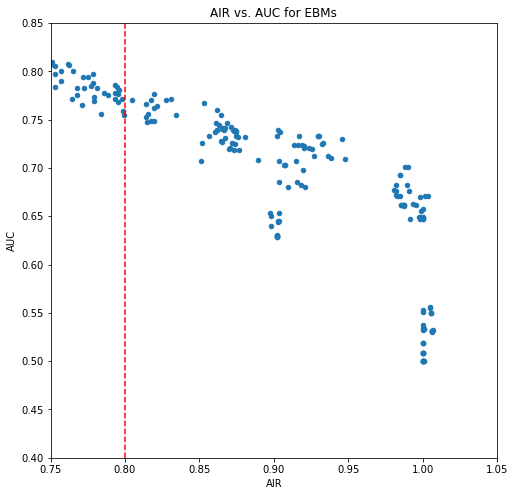

In [33]:
fig, ax = plt.subplots(figsize=(8,8))
_ = ebm_grid_frame.plot(kind='scatter', x='air', y='auc', title='AIR vs. AUC for EBMs', ax=ax)
_ = ax.axvline(x=0.8, color='r', linestyle='--')
_ = ax.set_ylim([0.4, 0.85])
_ = ax.set_xlim([0.75, 1.05])
_ = ax.set_xlabel('AIR')
_ = ax.set_ylabel('AUC')

Retrain most accurate model above 0.8 AIR

In [34]:
# extract new params dict from ebm_grid_frame
rem_params = ebm_grid_frame.loc[ebm_grid_frame['air'] > 0.8].sort_values(by='auc', ascending=False).iloc[0, :].to_dict()

# extract features from dict then delete from dict 
rem_x_names = rem_params['features']
del rem_params['features']

# record and delete other extraneous information
print('Best AUC: %.4f above 0.8 AIR (%.4f).' % (rem_params['auc'], rem_params['air']))
del rem_params['auc']
del rem_params['air']

# reset some parameters to integers
rem_params['random_state'] = int(rem_params['random_state'])
rem_params['n_jobs'] = int(rem_params['n_jobs'])

# retrain
rem_ebm = ExplainableBoostingClassifier(**rem_params)
rem_ebm.fit(train[rem_x_names], train[y_name]) 
rem_ebm_perf = ROC(rem_ebm.predict_proba).explain_perf(valid[rem_x_names], valid[y_name])
rem_auc = rem_ebm_perf._internal_obj['overall']['auc']
print('Remediated EBM retrained with AUC: %.4f.' % rem_auc)

Best AUC: 0.7764 above 0.8 AIR (0.8195).
Remediated EBM retrained with AUC: 0.7764.


Check that other groups are not adversely impacted by change

In [35]:
# create a frame with remediated EBM predictions
best_ebm_phat2 = pd.DataFrame(rem_ebm.predict_proba(valid[rem_x_names])[:, 1], columns=['phat']) 
best_ebm_phat2 = pd.concat([valid.reset_index(drop=True), best_ebm_phat2], axis=1)

# calculate new confusion matrices for each group
rem_cm_dict2 = {}
for name in demographic_group_names:
    rem_cm_dict2[name] = get_confusion_matrix(best_ebm_phat2, y_name, 'phat', by=name, level=1, cutoff=0.17, verbose=False)

# calculate AIR for each group
print('Adverse impact ratio for Asian people vs. White people: %.3f' % air(rem_cm_dict2, 'white', 'asian', verbose=False))
print('Adverse impact ratio for Black people vs. White people: %.3f' % air(rem_cm_dict2, 'white', 'black', verbose=False))
print('Adverse impact ratio for Females vs. Males: %.3f' % air(rem_cm_dict2, 'male', 'female', verbose=False))

Adverse impact ratio for Asian people vs. White people: 1.139
Adverse impact ratio for Black people vs. White people: 0.819
Adverse impact ratio for Females vs. Males: 0.954


Select percentiles from predictions

In [30]:
best_ebm_percentiles = get_percentile_dict('phat', best_ebm_phat, 'row_id')
for key in sorted(best_ebm_percentiles.keys()):
    print(str(key) + ': ' + str(best_ebm_percentiles[key]))

0: 140239
10: 20342
20: 80281
30: 110616
40: 4483
50: 25863
60: 1638
70: 28786
80: 154344
90: 65880
99: 48124


Calculate EBM contributions

In [32]:
# start local timer
ebm_tic = time.time()

# use EBM feature scores as local importance
# use mean abs score as global importance
best_ebm_contribs = best_ebm.explain_local(valid[x_names])
names = best_ebm_contribs._internal_obj['specific'][0]['names']
best_ebm_contribs_df = pd.DataFrame(columns=names)

# extract scores from insane _internal_obj
# new versions just have predict_and_explain() function
# use that if you can
for i in range(0, valid.shape[0]):
    row_df = pd.DataFrame(np.array(best_ebm_contribs._internal_obj['specific'][i]['scores']).reshape(1, 25), columns=names)
    best_ebm_contribs_df = best_ebm_contribs_df.append(row_df, ignore_index=True)
    del row_df
    
# end local timer
ebm_toc = time.time() - ebm_tic
print('EBM contributions collected in %.2f s.' % (ebm_toc))

EBM contributions collected in 145.54 s.


Collect global feature importance info

In [33]:
global_fi['EBM Importance'] = np.abs(best_ebm_contribs_df).mean()

Collect local feature importance info

In [34]:
# extract scores at three percentiles of phat
for percentile in [10, 50, 90]:
 
    # using valid_idx_map and percentiles dict
    # to find the right local contributions
    idx = valid_idx_map[valid_idx_map == int(best_ebm_percentiles[percentile])].index[0]
    s_df = best_ebm_contribs_df.iloc[idx, :len(x_names)].T
    s_df.columns = ['EBM Contribution']
    local_fi_dict[percentile]['EBM Contribution'] = s_df

#### Write submission file

In [35]:
best_ebm_submit = pd.DataFrame(best_ebm.predict_proba(test[x_names])[:, 1], columns=['phat'])
best_ebm_submit.to_csv('group4_best_ebm_' + str(datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S") + '.csv'), 
                        index=False)

## Analyze feature importance 
Compare global feature importance across models

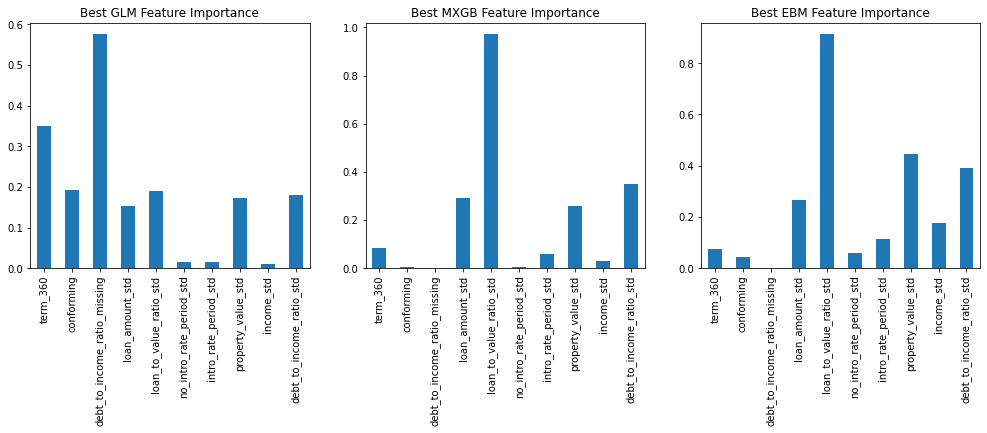

In [36]:
# init 3-pane plot 
fig, (ax0, ax1, ax2) = plt.subplots(ncols=3)
plt.tight_layout()
plt.subplots_adjust(left=0, right=2.2, wspace=0.2)

# plot global FI across three panes
_ = global_fi['GLM Importance'].plot(kind='bar', ax=ax0, title='Best GLM Feature Importance')
_ = global_fi['MXGB Importance'].plot(kind='bar', ax=ax1, title='Best MXGB Feature Importance')
_ = global_fi['EBM Importance'].plot(kind='bar', ax=ax2, title='Best EBM Feature Importance')

Compare local feature importance across models

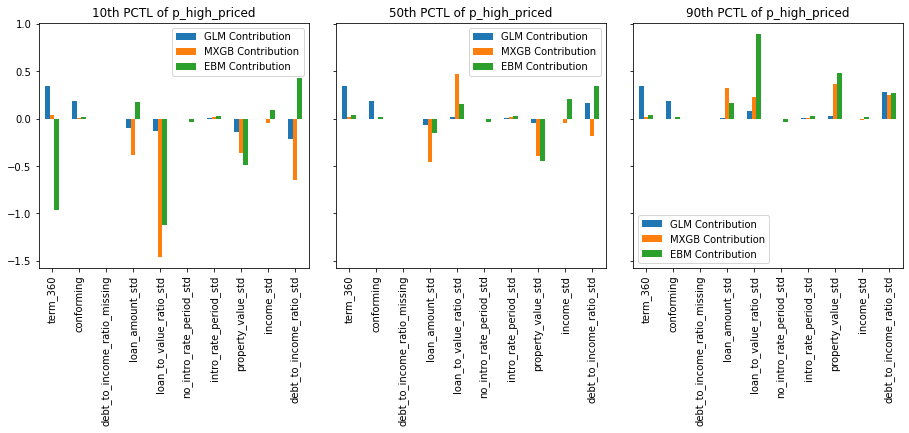

In [37]:
## init 3-pane plot 
fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, sharey=True)
plt.tight_layout()
plt.subplots_adjust(left=0, right=2, wspace=0.1)

# plot comparisons of local FI across 3 panes
_ = local_fi_dict[10].plot(kind='bar', ax=ax0,
                             title='10th PCTL of p_high_priced')

_ = local_fi_dict[50].plot(kind='bar', ax=ax1,
                             title='50th PCTL of p_high_priced')

_ = local_fi_dict[90].plot(kind='bar', ax=ax2,
                             title='90th PCTL of p_high_priced')

Utility function for partial dependence

In [38]:
def par_dep(x_name, valid, model, model_type, resolution=20, bins=None):

    """ Creates Pandas DataFrame containing partial dependence or ICE
        for a single input variable.
        :param x_name: Variable for which to calculate partial dependence.
        :param valid: Pandas validation frame.
        :param model: Trained model object (assumes binary classifier).
        :param model_type: Kind of model: h2o, xgb, or ebm.
        :param resolution: The number of points across the domain of xs for which
                           to calculate partial dependence, default 20.
        :param bins: List of values at which to set xs, default 20 equally-spaced
                     points between column minimum and maximum.
        :return: Pandas DataFrame containing partial dependence values.
    """

    # turn off pesky Pandas copy warning
    pd.options.mode.chained_assignment = None

    # determine values at which to calculate partial dependence
    if bins is None:
        min_ = valid[x_name].min()
        max_ = valid[x_name].max()
        by = (max_ - min_) / resolution
        # modify max and by
        # to preserve resolution and actually search up to max
        bins = np.arange(min_, (max_ + by), (by + np.round((1. / resolution) * by, 3)))
        
    # cache original column values
    col_cache = valid.loc[:, x_name].copy(deep=True)

    # calculate partial dependence
    # by setting column of interest to constant
    # and scoring the altered data and taking the mean of the predictions
    temp_df = valid.copy(deep=True)
    temp_df.loc[:, x_name] = bins[0]
    for j, _ in enumerate(bins):
        if j + 1 < len(bins):
            valid.loc[:, x_name] = bins[j + 1]
            temp_df = temp_df.append(valid, ignore_index=True)

    # return input frame to original cached state
    valid.loc[:, x_name] = col_cache

    # model predictions
    # probably assumes binary classification
    if model_type == 'h2o':
        temp_df['partial_dependence'] = model.predict(h2o.H2OFrame(temp_df))['p1'].as_data_frame()
    if model_type == 'xgb':
        temp_df['partial_dependence'] = pd.DataFrame(model.predict(xgb.DMatrix(temp_df), ntree_limit=best_mxgb.best_ntree_limit), columns=['phat'])
    if model_type == 'ebm':
        temp_df['partial_dependence'] = pd.DataFrame(model.predict_proba(temp_df)[:, 1], columns=['phat'])
    
    return pd.DataFrame(temp_df[[x_name, 'partial_dependence']].groupby([x_name]).mean()).reset_index()

Calculate partial dependence for all X and models

In [39]:
# start local timer
pd_tic = time.time()

# init dict to hold results
pd_dict = {}

# cycle through names and model types to calculate par dep
for name in x_names:
    
    print('Calculating partial dependence for %s ...' % name)
    
    # setup a dataframe to hold results
    # use bins from first par_dep() run
    pd_dict[name] = pd.DataFrame(columns=[name, 'h2o', 'xgb', 'ebm'])
    first_pd = par_dep(name, valid[x_names], best_glm, 'h2o')
    pd_dict[name][name] = first_pd[name]
    bins = first_pd[name]
    pd_dict[name]['h2o'] = first_pd['partial_dependence']
    
    # calculate par dep for remaining models
    pd_dict[name]['xgb'] = par_dep(name, valid[x_names], best_mxgb, 'xgb', bins=bins)['partial_dependence']
    pd_dict[name]['ebm'] = par_dep(name, valid[x_names], best_ebm, 'ebm', bins=bins)['partial_dependence']
    
print('Done.')

# end local timer
pd_toc = time.time() - pd_tic
print('Partial dependence calculated in %.2f s.' % (pd_toc))

Calculating partial dependence for term_360 ...
C:\Users\cbett\miniconda3\lib\site-packages\xgboost\core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
Calculating partial dependence for conforming ...
Calculating partial dependence for debt_to_income_ratio_missing ...
Calculating partial dependence for loan_amount_std ...
Calculating partial dependence for loan_to_value_ratio_std ...
Calculating partial dependence for no_intro_rate_period_std ...
Calculating partial dependence for intro_rate_period_std ...
Calculating partial dependence for property_value_std ...
Calculating partial dependence for income_std ...
Calculating partial dependence for debt_to_income_ratio_std ...
Done.
Partial dependence calculated in 349.82 s.


Plot partial dependence for all features and models

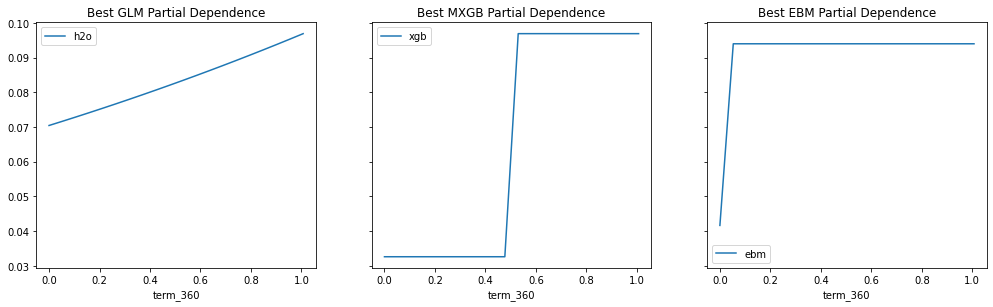

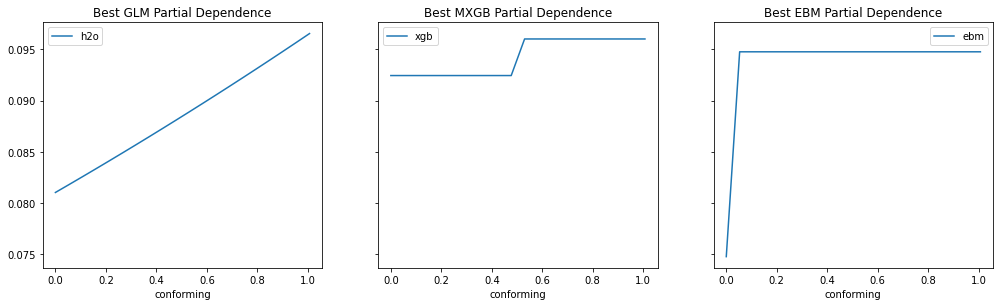

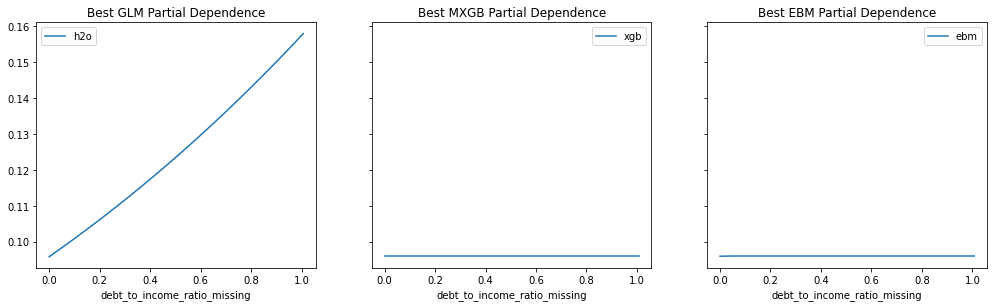

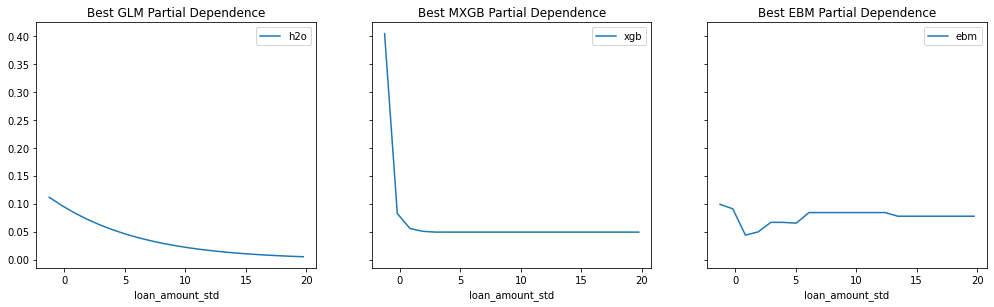

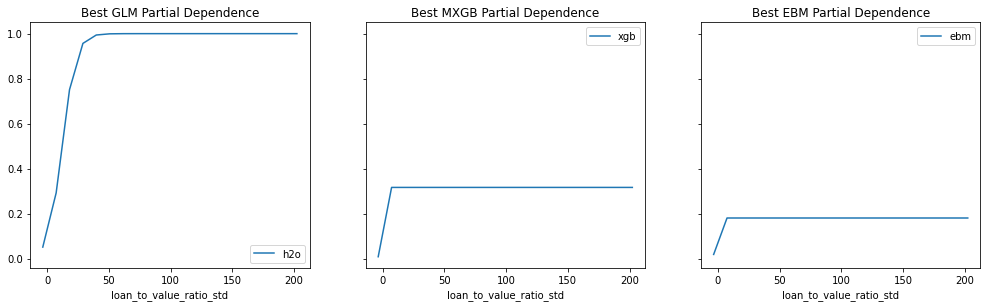

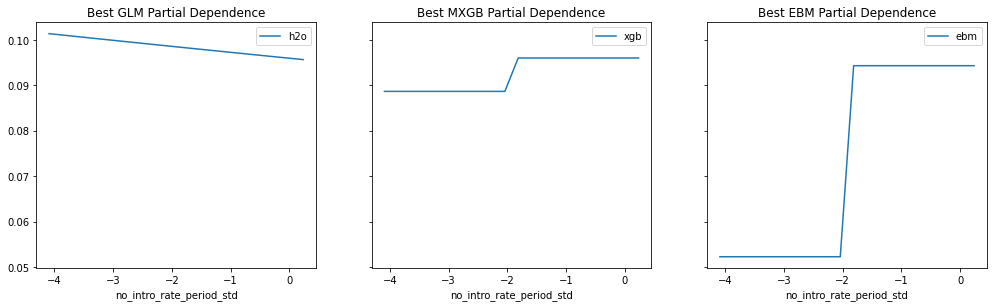

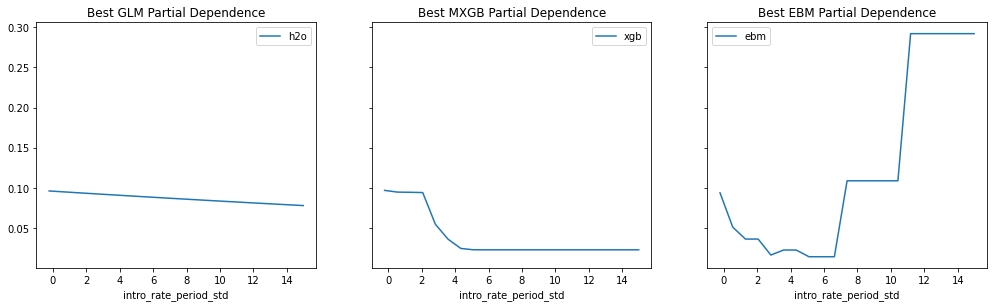

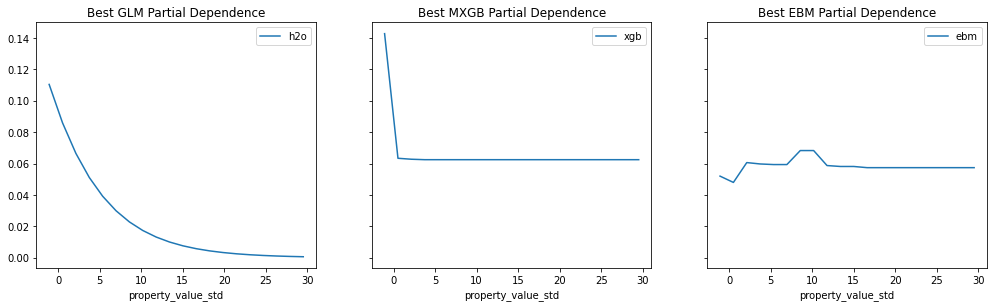

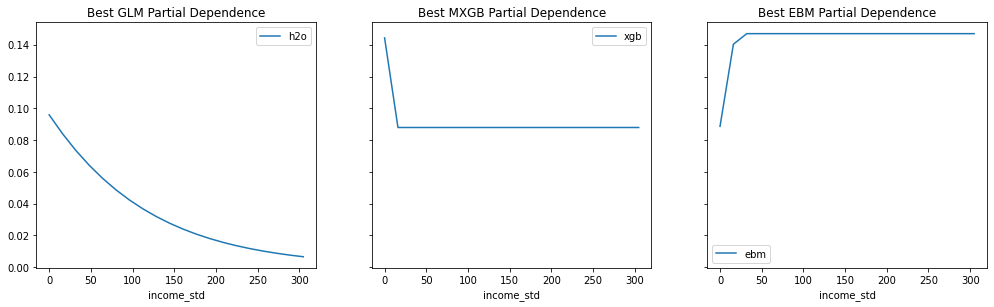

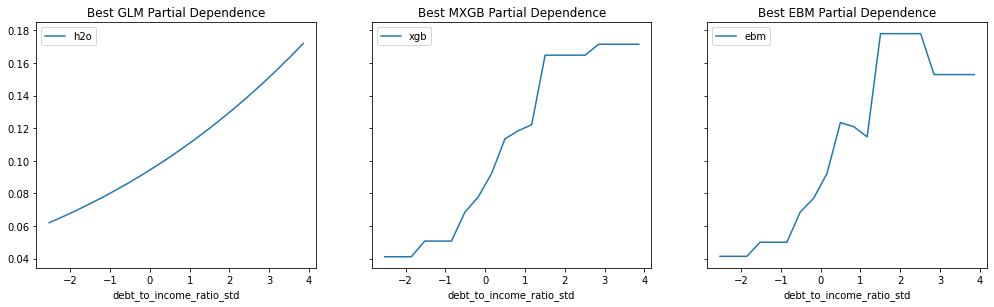

In [40]:
# loop through names to calculate par dep 
for name in x_names:
    
    # init 3-pane plot
    fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, sharey=True)
    plt.tight_layout()
    plt.subplots_adjust(left=0, right=2.2, wspace=0.2)
  
    # plot par dep from each model across frames
    pd_dict[name].plot(kind='line', x=name, y='h2o', ax=ax0, title='Best GLM Partial Dependence')
    ax0.set_xlabel(name)
    pd_dict[name].plot(kind='line', x=name, y='xgb', ax=ax1, title='Best MXGB Partial Dependence') 
    ax1.set_xlabel(name)
    pd_dict[name].plot(kind='line', x=name, y='ebm', ax=ax2, title='Best EBM Partial Dependence')
    ax2.set_xlabel(name)

## Clean Up

#### End timer

In [36]:
toc = time.time() - tic
print('All tasks completed in %.2f s.' % (toc))

All tasks completed in 22858.21 s.


#### Shutdown h2o

In [37]:
h2o.cluster().shutdown(prompt=False)

H2O session _sid_8d5c closed.
